In [84]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
import os

In [67]:
# mình có S (n*n), X là symetric
# G >= 0, X >= 0
# S = X * X^T
np.random.seed(42)



def load_adj_matrix(filename: str):
    """
     file:  dimacs10-football/out.dimacs10-football" or "facebook_combined.txt"
     Undirected graph
    """
    with open(filename, "r") as file:
        adj_list = np.array([tuple(map(int, line.split())) for line in file])

    max_node = max(max(edge) for edge in adj_list) + 1
    adj_matrix = np.zeros((max_node, max_node))

    for node1, node2 in adj_list:
        adj_matrix[node1][node2] = 1
        adj_matrix[node2][node1] = 1

    print('>> Max node:', max_node)
    print('>> Adj_matrix: \n', adj_matrix)
    return adj_matrix, adj_list

G, adj_list = load_adj_matrix("facebook_combined.txt")

# G = np.random.randint(0, 1, (2000,2000))
G.shape

>> Max node: 4039
>> Adj_matrix: 
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4039, 4039)

In [92]:
class SNMF():
    def __init__(
        self,
        adj_matrix: np.ndarray,
        adj_list: np.ndarray = None,
        dimensions: int = 32,
        iterations: int = 600,
        seed: int = 42
    ):
        self.adj_matrix = adj_matrix
        self.adj_list = adj_list
        self.num_node = adj_matrix.shape[0]
        self.num_edge = adj_list.shape[0]
        self.dimensions = dimensions
        self.iterations = iterations
        self.seed = seed

    # def __del__(self):
    #     np.random.seedseq([]) # Reset the RNG


    def modularity(self, adj_matrix, communities: np.ndarray):
        assert adj_matrix.shape[0] == communities.shape[0]
        assert len(communities.shape) == 1
        assert adj_matrix.shape[0] == adj_matrix.shape[1]
        n = adj_matrix.shape[0]
        m = np.sum(adj_matrix) # number of edges
        k = np.sum(adj_matrix, axis=1) # degree of each node

        Q = 0
        for i in range(n):
            for j in range(n):
                sig = 1 if communities[i] == communities[j] else 0
                Q += (adj_matrix[i][j] - (k[i] * k[j] / (2*m))) * sig / (2*m)

        return Q

    # def get_memberships(self):
    #     r"""Getting the cluster membership of nodes.

    #     Return types:
    #         * **memberships** *(dict)* - Node cluster memberships.
    #     """
    #     index = np.argmax(self._W, axis=1)
    #     memberships = {int(i): int(index[i]) for i in range(len(index))}
    #     return memberships
    
    def _set_seed(self):
        np.random.seed(self.seed)

    def update(self, G,X):
        numerator = G @ X # Top
        denominator = 2 * X @ X.T @ X  # Bottom
        newX = X * (1/2 + (numerator / denominator))
        return newX

    def get_loss(self, G,X):
        tar = G - X @ X.T
        loss = np.linalg.norm(tar) ** 2
        return loss


    def fit(self, dim: int = 32, clear_stats: bool = False):
        self._set_seed()

        X = np.random.rand(self.num_node, dim) # Start
        losses = []

        os.makedirs(f'results/snmf/runs_{dim}', exist_ok=True)
        print(f"Directory results/snmf/runs_{dim} created successfully!")

        # Iteration
        start_time = time.time()
        for i in tqdm(range(self.iterations)):
            # print(f'>> Iter {i}')
            X = self.update(self.adj_matrix,X)
            loss = self.get_loss(self.adj_matrix,X)

            if i > 0 and losses[-1] - loss < 1e-8:
                print(f'>> Early stopping at iteration {i}')
                break

            losses.append(loss)
        elapsed_time = time.time() - start_time
        
        print('Done iteration!!!')

        # Loss-epochs
        losses_df = pd.DataFrame({"epoch": range(len(losses)), "loss": losses})
        losses_df.to_csv(f'results/snmf/runs_{dim}/losses.csv', index=False)
        print("Done saved losses CSV")
        
        # Save images 
        plt.plot(losses)
        plt.xlabel("Number of epochs")  # Adjust as needed
        plt.ylabel("Loss")
        plt.title(f"Loss of SNMF over time with {dim} communities")
        plt.savefig(f'results/snmf/runs_{dim}/losses.png')
        print('Done saved losses image')

        # Save X
        np.savetxt(f'results/snmf/runs_{dim}/X.txt', X)
        print('Done saved X')

        # Save probabilities
        normalizedX = X / np.sum(X, axis=1, keepdims=True)
        np.savetxt(f'results/snmf/runs_{dim}/prob.txt', normalizedX, fmt='%.2f')
        print('Done saved Probabilities')


        # Community
        communities = np.argmax(X, axis=1)
        np.savetxt(f'results/snmf/runs_{dim}/communities.txt', communities, fmt='%d')
        print('Done saved Community')

        
        # Log lại


        # num_communities, modularity, epoch_stop, elapsed_time
        stats_path = f"results/snmf/stats.csv"

        if clear_stats:
            os.remove(stats_path)

        # Check if the file exists
        if not os.path.exists(stats_path):
            stats_df = pd.DataFrame(columns=["num_communities", "modularity", "losses", "epoch_stop", "elapsed_time"])
        else:
            stats_df = pd.read_csv(stats_path)

        new_row = {
            "num_communities": dim,
            "modularity": self.modularity(self.adj_matrix, communities),
            "losses": losses[-1],
            "epoch_stop": i,
            "elapsed_time": elapsed_time
        }
        new_df = pd.DataFrame([new_row])
        stats_df = pd.concat([stats_df, new_df], ignore_index=True)

        stats_df.to_csv(stats_path, index=False)
        print('Done save general stats')

    def fit_all(self, low: int, high: int):
        for comm in range(low, high + 1):
            print(f'>>> Community {comm} >>>')
            self.fit(comm)
        


# f'results/snmf/stats.csv'
# np.around(X @ X.T, decimals=2)

In [93]:
G, adj_list = load_adj_matrix("facebook_combined.txt")
snmf = SNMF(G,adj_list)
snmf.fit_all(2,100)

Exception ignored in: <function SNMF.__del__ at 0x7f8399020790>
Traceback (most recent call last):
  File "/var/folders/c3/9m2ftf2n52b_0sff1m9yvnmh0000gn/T/ipykernel_33270/2517539545.py", line 19, in __del__
AttributeError: module 'numpy.random' has no attribute 'seedseq'


>> Max node: 4039
>> Adj_matrix: 
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
>>> Community 2 >>>
Directory results/snmf/runs_2 created successfully!


 38%|███▊      | 226/600 [00:40<01:07,  5.56it/s]


>> Early stopping at iteration 226
Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community


/var/folders/c3/9m2ftf2n52b_0sff1m9yvnmh0000gn/T/ipykernel_33270/443071149.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat([stats_df, new_df], ignore_index=True)


Done save general stats
>>> Community 3 >>>
Directory results/snmf/runs_3 created successfully!


100%|██████████| 600/600 [01:45<00:00,  5.71it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 4 >>>
Directory results/snmf/runs_4 created successfully!


100%|██████████| 600/600 [01:46<00:00,  5.63it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 5 >>>
Directory results/snmf/runs_5 created successfully!


100%|██████████| 600/600 [01:40<00:00,  5.95it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 6 >>>
Directory results/snmf/runs_6 created successfully!


100%|██████████| 600/600 [01:42<00:00,  5.87it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 7 >>>
Directory results/snmf/runs_7 created successfully!


100%|██████████| 600/600 [01:42<00:00,  5.88it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 8 >>>
Directory results/snmf/runs_8 created successfully!


100%|██████████| 600/600 [01:42<00:00,  5.87it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 9 >>>
Directory results/snmf/runs_9 created successfully!


100%|██████████| 600/600 [01:44<00:00,  5.75it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 10 >>>
Directory results/snmf/runs_10 created successfully!


100%|██████████| 600/600 [01:45<00:00,  5.67it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 11 >>>
Directory results/snmf/runs_11 created successfully!


100%|██████████| 600/600 [01:49<00:00,  5.48it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 12 >>>
Directory results/snmf/runs_12 created successfully!


100%|██████████| 600/600 [01:47<00:00,  5.58it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 13 >>>
Directory results/snmf/runs_13 created successfully!


100%|██████████| 600/600 [01:49<00:00,  5.48it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 14 >>>
Directory results/snmf/runs_14 created successfully!


100%|██████████| 600/600 [01:47<00:00,  5.57it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 15 >>>
Directory results/snmf/runs_15 created successfully!


100%|██████████| 600/600 [01:38<00:00,  6.11it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 16 >>>
Directory results/snmf/runs_16 created successfully!


100%|██████████| 600/600 [01:44<00:00,  5.76it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 17 >>>
Directory results/snmf/runs_17 created successfully!


100%|██████████| 600/600 [01:52<00:00,  5.32it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 18 >>>
Directory results/snmf/runs_18 created successfully!


100%|██████████| 600/600 [01:56<00:00,  5.16it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 19 >>>
Directory results/snmf/runs_19 created successfully!


100%|██████████| 600/600 [01:50<00:00,  5.45it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 20 >>>
Directory results/snmf/runs_20 created successfully!


100%|██████████| 600/600 [01:52<00:00,  5.32it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 21 >>>
Directory results/snmf/runs_21 created successfully!


100%|██████████| 600/600 [01:57<00:00,  5.12it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 22 >>>
Directory results/snmf/runs_22 created successfully!


100%|██████████| 600/600 [01:59<00:00,  5.02it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 23 >>>
Directory results/snmf/runs_23 created successfully!


100%|██████████| 600/600 [01:55<00:00,  5.18it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 24 >>>
Directory results/snmf/runs_24 created successfully!


100%|██████████| 600/600 [01:52<00:00,  5.33it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 25 >>>
Directory results/snmf/runs_25 created successfully!


100%|██████████| 600/600 [01:57<00:00,  5.12it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 26 >>>
Directory results/snmf/runs_26 created successfully!


100%|██████████| 600/600 [01:51<00:00,  5.40it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 27 >>>
Directory results/snmf/runs_27 created successfully!


100%|██████████| 600/600 [02:28<00:00,  4.04it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 28 >>>
Directory results/snmf/runs_28 created successfully!


100%|██████████| 600/600 [02:46<00:00,  3.61it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 29 >>>
Directory results/snmf/runs_29 created successfully!


100%|██████████| 600/600 [02:37<00:00,  3.81it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 30 >>>
Directory results/snmf/runs_30 created successfully!


100%|██████████| 600/600 [02:39<00:00,  3.75it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 31 >>>
Directory results/snmf/runs_31 created successfully!


100%|██████████| 600/600 [03:00<00:00,  3.33it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 32 >>>
Directory results/snmf/runs_32 created successfully!


100%|██████████| 600/600 [02:53<00:00,  3.46it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 33 >>>
Directory results/snmf/runs_33 created successfully!


100%|██████████| 600/600 [02:55<00:00,  3.41it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 34 >>>
Directory results/snmf/runs_34 created successfully!


100%|██████████| 600/600 [02:50<00:00,  3.52it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 35 >>>
Directory results/snmf/runs_35 created successfully!


100%|██████████| 600/600 [02:53<00:00,  3.46it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 36 >>>
Directory results/snmf/runs_36 created successfully!


100%|██████████| 600/600 [02:47<00:00,  3.58it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 37 >>>
Directory results/snmf/runs_37 created successfully!


100%|██████████| 600/600 [02:48<00:00,  3.56it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 38 >>>
Directory results/snmf/runs_38 created successfully!


100%|██████████| 600/600 [02:52<00:00,  3.48it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 39 >>>
Directory results/snmf/runs_39 created successfully!


100%|██████████| 600/600 [03:17<00:00,  3.04it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 40 >>>
Directory results/snmf/runs_40 created successfully!


100%|██████████| 600/600 [05:59<00:00,  1.67it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 41 >>>
Directory results/snmf/runs_41 created successfully!


100%|██████████| 600/600 [04:20<00:00,  2.30it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 42 >>>
Directory results/snmf/runs_42 created successfully!


100%|██████████| 600/600 [03:26<00:00,  2.91it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community
Done save general stats
>>> Community 43 >>>
Directory results/snmf/runs_43 created successfully!


100%|██████████| 600/600 [02:57<00:00,  3.38it/s]


Done iteration!!!
Done saved losses CSV
Done saved losses image
Done saved X
Done saved Probabilities
Done saved Community


In [71]:
print(pd.__version__)

2.1.2


In [62]:
import os

In [60]:
for i in range(10):
    if i == 5: break
print(i)

5


In [25]:
# 6000 * 6000 (maxtrix)
# 400 iterations

X = np.random.rand(4039, 20) # Start
iter = 100

losses = []

######### Main function
print('Start X: ')
print(X)
print('Start loss: ', get_loss(G,X))
losses.append(get_loss(G,X))

for i in range(iter):
    print(f'>> Iter {i}')
    X = update(G,X)
    # print('Updated X: ')
    # print(X)

    loss = get_loss(G,X)
    # print('Loss: ', loss)

    # if i > 0 and losses[i - 1] - loss < 1e-8:
    #     print(f'>> Early stopping at iteration {i}')
    #     break

    losses.append(get_loss(G,X))
    # break

print('Done')



# 9.2s - 100 epochs 1000*1000, 500 => 0.092s / 1 epoch => 400: 1min
# 0.6s (2000, 1000) => 4 min 
# 1.7s / 1 epoch (3000, 1500) => 400 epoch => 10 min
# 6s/1 epoch 5000*5000, 2500 , 400 epoch => 40p
# 38s - 1 epochs 10000*10000, 5000 com

Start X: 
[[0.89781435 0.45480388 0.73218077 ... 0.60171766 0.52276777 0.1916887 ]
 [0.2875126  0.83246715 0.61453149 ... 0.07354334 0.12758523 0.4275863 ]
 [0.10935597 0.19059802 0.33712274 ... 0.65081115 0.26493479 0.43509739]
 ...
 [0.34577009 0.80173598 0.863764   ... 0.77859926 0.21266296 0.05909124]
 [0.50574088 0.85117792 0.72119321 ... 0.50119202 0.06991729 0.50458978]
 [0.73050179 0.59209105 0.62681916 ... 0.43686913 0.13415834 0.00737057]]
Start loss:  416942209.9173124
>> Iter 0
>> Iter 1
>> Iter 2
>> Iter 3
>> Iter 4
>> Iter 5
>> Iter 6
>> Iter 7
>> Iter 8
>> Iter 9
>> Iter 10
>> Iter 11
>> Iter 12
>> Iter 13
>> Iter 14
>> Iter 15
>> Iter 16
>> Iter 17
>> Iter 18
>> Iter 19
>> Iter 20
>> Iter 21
>> Iter 22
>> Iter 23
>> Iter 24
>> Iter 25
>> Iter 26
>> Iter 27
>> Iter 28
>> Iter 29
>> Iter 30
>> Iter 31
>> Iter 32
>> Iter 33
>> Iter 34
>> Iter 35
>> Iter 36
>> Iter 37
>> Iter 38
>> Iter 39
>> Iter 40
>> Iter 41
>> Iter 42
>> Iter 43
>> Iter 44
>> Iter 45
>> Iter 46
>> Iter 

In [30]:
np.savetxt("x.txt", X)

tmp = np.loadtxt("x.txt")
tmp

In [31]:
tmp = np.loadtxt("x.txt")
tmp

array([[3.52471867e-001, 1.31472313e-001, 1.91488297e-034,
        7.60821148e-089, 9.49063356e-001],
       [4.09645062e-001, 1.31484723e-001, 2.12261517e-034,
        2.73358523e-089, 9.25821260e-001],
       [2.92689668e-001, 8.03270005e-001, 1.20206429e-001,
        1.25020079e-001, 7.20403328e-001],
       [4.94065646e-324, 1.04556493e-009, 2.97763520e-001,
        1.00199478e+000, 4.94065646e-324],
       [1.83108644e-007, 7.56359991e-001, 3.13950551e-001,
        7.55462497e-001, 4.12873599e-004]])

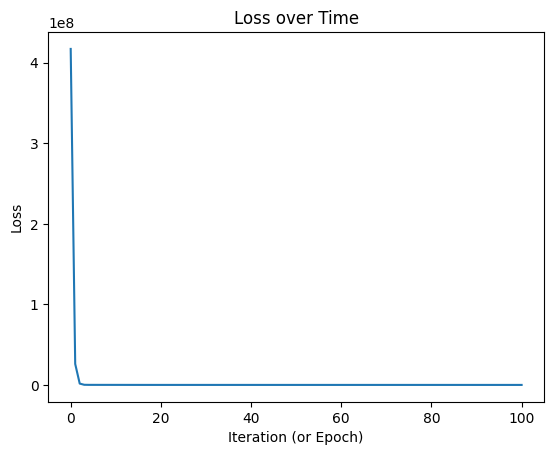

In [26]:
plt.plot(losses)

# Optional customizations
plt.xlabel("Iteration (or Epoch)")  # Adjust as needed
plt.ylabel("Loss")
plt.title("Loss over Time")

# Display the plot
plt.show()

In [27]:
X

array([[3.00319105e-03, 8.19125254e-03, 4.86699918e-02, ...,
        3.56390682e-29, 1.45124293e-02, 4.08822428e-05],
       [4.59748200e-19, 6.24753939e-24, 1.84138366e-13, ...,
        3.95880223e-31, 1.44597851e-14, 4.51058930e-30],
       [6.82184093e-24, 4.83995034e-20, 8.38738719e-04, ...,
        3.81626935e-30, 1.14285968e-04, 1.52034562e-30],
       ...,
       [7.24785034e-14, 7.33204238e-31, 2.33893782e-30, ...,
        1.47685143e-30, 5.06739388e-31, 9.23287188e-32],
       [1.03833221e-14, 9.30236285e-31, 4.01334926e-30, ...,
        1.31009148e-30, 2.61796202e-31, 8.40674916e-31],
       [2.36765190e-13, 8.41317271e-31, 6.63902602e-30, ...,
        1.25051781e-30, 7.34624329e-31, 1.42342471e-32]])

In [28]:
normalizedX = X / np.sum(X, axis=1, keepdims=True)

print(normalizedX)

np.around(normalizedX, decimals=2)

[[1.56794341e-03 4.27659120e-03 2.54102358e-02 ... 1.86068888e-29
  7.57682993e-03 2.13443107e-05]
 [2.50943850e-18 3.41008750e-23 1.00508040e-12 ... 2.16082863e-30
  7.89256846e-14 2.46200996e-29]
 [1.08091994e-22 7.66889594e-19 1.32898057e-02 ... 6.04687455e-29
  1.81085989e-03 2.40898594e-29]
 ...
 [3.85550916e-09 3.90029530e-26 1.24420287e-25 ... 7.85614210e-26
  2.69561078e-26 4.91144553e-27]
 [5.12847350e-10 4.59457204e-26 1.98225146e-25 ... 6.47073200e-26
  1.29304945e-26 4.15221544e-26]
 [4.03728820e-09 1.43460290e-26 1.13207779e-25 ... 2.13236617e-26
  1.25267153e-26 2.42720468e-28]]


array([[0.  , 0.  , 0.03, ..., 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [29]:
argmax_indices = np.argmax(X, axis=1)

print(argmax_indices)  # Output: [1 2 0]

# Thêm threshold để có vài điêm3 ko rõ vị trí

[8 8 8 ... 4 4 4]


In [36]:
# print(X @ X.T)

np.around(X @ X.T, decimals=2)

array([[1.  , 1.  , 0.97, 0.  , 0.17],
       [1.  , 1.  , 0.97, 0.  , 0.17],
       [0.97, 0.97, 1.12, 0.39, 0.62],
       [0.  , 0.  , 0.39, 0.84, 0.98],
       [0.17, 0.17, 0.62, 0.98, 1.17]])

In [ ]:
# Inferences
X optimize the is just the scale partition matrix of the network G of size n * K
i-th row corresponds to the cluster (community) membership of the i-th unit.

Có thể normalize sum của hàng = 1 để ra  posterior probability that the i-th unit belongs to the k-th community (xác suất)



In [ ]:
G có weighted, số paper mà 2 node có

In [ ]:
We first treat G as the similarity matrix between authors and apply K-means algorithm to initialize the scaled partition matrix 

K =  2
1.1666666666666667
K =  3
0.5


/Users/lap14179/anaconda3/envs/maxflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/lap14179/anaconda3/envs/maxflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: x and y must have same first dimension, but have shapes (9,) and (2,)

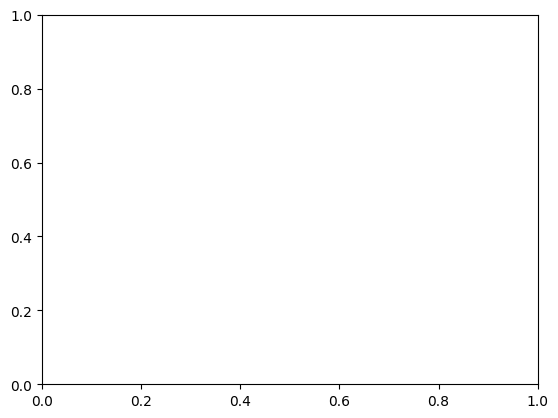

In [44]:
from sklearn.cluster import KMeans

inertia_values = []
for k in range(2, 4):  # Try different values of k
    print('K = ', k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(G)
    inertia_values.append(kmeans.inertia_)
    print(kmeans.inertia_)

# Plot inertia to visualize the elbow
import matplotlib.pyplot as plt
plt.plot(range(2, 11), inertia_values)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# Tạo 1 cái link khác, nếu độ dài này từ đâu tới đâu, 
# 

In [60]:
adj_matrix = np.array([[0, 1, 1, 0],
                       [1, 0, 1, 1],
                       [1, 1, 0, 0],
                       [0, 1, 0, 0]])  # Replace with your adjacency matrix
com_dict = {0: 0, 1: 0, 2: 0, 3: 1}  # Replace with your community dictionary


def calculate_modularity(adj_matrix, com_dict):
    n = len(adj_matrix)
    m = np.sum(adj_matrix) / 2  # Total number of edges

    communities = set(com_dict.values())
    Q = 0

    for c in communities:
        nc = sum(com_dict[i] == c for i in com_dict)
        dc = sum(np.sum(adj_matrix[i, :] + adj_matrix[:, i]) for i in com_dict if com_dict[i] == c)
        Q += (dc / m) - (nc * (nc - 1) / (4 * m))

    return Q

Q = calculate_modularity(adj_matrix, com_dict)
print("Modularity:", Q)

Modularity: 3.625


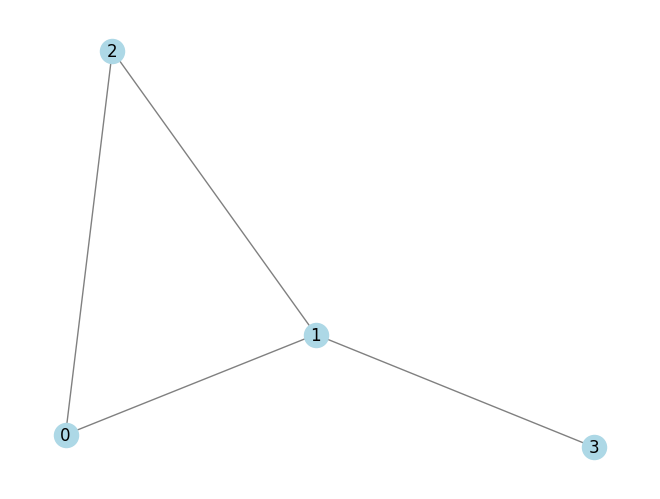

In [61]:
import networkx as nx

G = nx.from_numpy_array(adj_matrix)
pos = nx.spring_layout(G)  # For a spring-like layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
# plt.savefig("graph.png")
# plt.close()

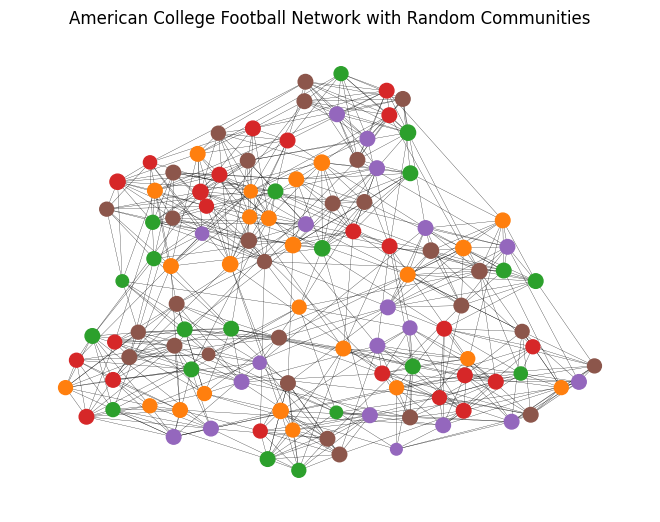

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import random

import urllib.request
import io
import zipfile

import matplotlib.pyplot as plt
import networkx as nx

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data

from networkx.algorithms.community import greedy_modularity_communities

# Detect communities
communities = greedy_modularity_communities(G)
community_assignment = [i + 1 for i in community_membership(communities)]

# Apply a layout that often preserves community structure
pos = nx.spectral_layout(G)

# Draw the graph with community-based colors
nx.draw(G, pos, node_color=community_colors, node_size=node_sizes, width=0.2, with_labels=False)
plt.title("American College Football Network with Detected Communities")
plt.show()

In [54]:
communities_dict = {}

for i in range(len(argmax_indices)):
    if argmax_indices[i] in communities_dict:
        communities_dict[argmax_indices[i]].append(i)
    else:
        communities_dict[argmax_indices[i]] = [i]

In [55]:
communities_dict

{8: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,

In [57]:
graph = graphviz.Graph(format='png', node_attr={'color': 'lightblue2', 'style': 'filled'})

# Add cluster
for comm, cluster in communities_dict.items():
    with graph.subgraph(name=f'Cluster {comm}') as c:
        c.attr(style='filled', color='lightgreen')
        for node in cluster:
            c.node(str(node))
        c.attr(label=f'Cluster {comm}')

# Add edge
for source, dest in adj_edge:
    graph.edge(str(source), str(dest))

In [58]:
graph.render('clusters')

KeyboardInterrupt: 

In [51]:
import graphviz

# Create a Graphviz graph object
graph = graphviz.Graph(format='png', node_attr={'color': 'lightblue2', 'style': 'filled'})

# Define clusters using subgraphs
with graph.subgraph(name='cluster_1') as c:
    c.attr(style='filled', color='lightgreen')
    c.node('0')
    c.node('1')
    c.node('2')
    c.attr(label='Cluster 1')

with graph.subgraph(name='cluster_2') as c:
    c.attr(style='filled', color='lightgreen')
    c.node('3')
    c.node('4')
    c.attr(label='Cluster 2')

# Add edges between nodes
graph.edge('0', '1')
graph.edge('1', '2')
graph.edge('2', '0')
graph.edge('3', '4')
graph.edge('0', '3')

# Render the graph as a PNG image
graph.render('clusters')


TypeError: expected string or bytes-like object

In [20]:
!pip install graphviz
!brew install graphviz

  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [59]:
!pip install tqdm

  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)


In [ ]:
# Overlapping
# Làm sao tìm được số communities
# Làm sao đo được